In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('labeled_healthcare_data.csv')
print(data.head())

                                    aid          authorProfileId  \
0  b686214b-2f6e-4818-bc3f-2fe8a9597a79      annette-a-77577a248   
1  ba295f35-ff33-4f94-bd3c-1307c6f123ba      zhen-zhang-7715644b   
2  0ccf95a0-ebf5-4dfb-96c9-e87aa964efbc   d-sc-ms-bitsch-0464645   
3  fb88c3cc-62ab-408f-8ea9-0fdd3f8a9f9c  hesham-sherif-0706ab154   
4  fb88c3cc-62ab-408f-8ea9-0fdd3f8a9f9c  hesham-sherif-0706ab154   

             name                                        authorTitle  \
0       AnnetteA.        Access Consultant | Advocating AI Solutions   
1       ZhenZhang  Director, Statistician Lead, Medical & Real-Wo...   
2  D.Sc. MSBITSCH  Standard. ORCID: 0000-0003-2035-3471. Doctor o...   
3    HeshamSherif    Certified Psychiatrist in 3 different countries   
4    HeshamSherif    Certified Psychiatrist in 3 different countries   

                                    pid  \
0  6a55b3be-2b50-41c1-8413-f0dffc9670be   
1  2db7a951-672a-46aa-8223-a3b2fd2b915c   
2  b1ce6d34-fe99-43e5-a433-0c

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
data['processed_text'] = data['text'].apply(preprocess_text)
print(data[['text', 'processed_text']].head())

                                                text  \
0  "Cannabidiol treatment is associated with broa...   
1  Data on early treatment for Bipolar-I disorder...   
2  #y24d067.2•Antipsychotic drugs list: publicati...   
3  Clozapine, risperidone, aripiprazole, and olan...   
4  The suggested recommendations include the foll...   

                                      processed_text  
0  cannabidiol treatment associated broadband spe...  
1  data early treatment bipolari disorder show be...  
2  ydantipsychotic drug list publication scrutiny...  
3  clozapine risperidone aripiprazole olanzapine ...  
4  suggested recommendation include following low...  


In [ ]:
!pip install transformers torch

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

tokenized_data = [tokenize_text(text) for text in data['processed_text']]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.detach()

data['bert_embeddings'] = data['processed_text'].apply(get_bert_embeddings)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = torch.stack(data['bert_embeddings'].tolist()).squeeze().numpy()
y = data['label']

In [ ]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       303
           1       0.14      0.07      0.09        30
           2       0.44      0.50      0.47       362
           3       0.18      0.11      0.14        79
           4       0.32      0.33      0.33       242

    accuracy                           0.41      1016
   macro avg       0.31      0.29      0.30      1016
weighted avg       0.40      0.41      0.40      1016



In [ ]:
import pickle

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)
tokenizer.save_pretrained('tokenizer/')
bert_model.save_pretrained('bert_model/')

In [ ]:
new_data = pd.read_csv('healthcare_actor_eval.csv')
print(new_data.head())

                                    aid         authorProfileId  \
0  7b861c01-ab28-42bc-9090-2dad2c6c6117          chakib-rachedi   
1  95320bff-177c-48a4-bac6-42a9b0e8b5e5           frankokosunmd   
2  206ba986-bcbb-4400-9f02-cc1cc869563d  nelson-jeckl-b1611614b   
3  6d1cf509-8cb8-4eeb-8eda-e2c2c26b696b   shane-hinze-a62b86266   
4  5aa7d614-6fa7-4711-9292-91c23490aebb                cchrvala   

                    name                                        authorTitle  \
0  ChakibRachedi, PharmD                      PharmD | Business Development   
1    FrankOkosun Jr., MD  Medical Director at Brazos Primary Care | Boar...   
2            NelsonJeckl  Senior Consultant - Life Science Engineering a...   
3             ShaneHinze                        Direct Sales Respresentatie   
4     CaroleChrvala, PhD  Epidemiologist with a passion for medical writ...   

                                    pid  \
0  1e95ebc8-5aab-48a3-aa95-5ca564a9303e   
1  3ce31432-6e61-47f3-9207-280e0543b

In [ ]:
new_data['processed_text'] = new_data['text'].apply(preprocess_text)

In [ ]:
new_data['bert_embeddings'] = new_data['processed_text'].apply(get_bert_embeddings)

In [ ]:
X_new = torch.stack(new_data['bert_embeddings'].tolist()).squeeze().numpy()

In [ ]:
new_data['predicted_label'] = model.predict(X_new)

In [ ]:
new_data.to_csv('predicted_results.csv', index=False)
print(new_data[['text', 'predicted_label']].head())

                                                text  predicted_label
0  1st week of November Updates:\n\n🚀 Halozyme, I...                3
1  We have always known that many medications hav...                4
2  𝑩𝑰𝑮 𝑷𝒉𝒂𝒓𝒎𝒂 𝑰𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝑼𝒑𝒅𝒂𝒕𝒆𝒔 - 𝒄𝒂𝒓𝒅𝒊𝒐𝒎𝒆𝒕𝒂𝒃𝒐𝒍𝒊...                1
3  I’m very happy to announce I will be starting ...                3
4  A 60% reduction is certainly of clinical as we...                2


In [ ]:
label_mapping = {
    0: "Healthcare Provider",
    1: "Patient",
    2: "Payers and Insurers",
    3: "Pharmaceutical Representative",
    4: "Regulator"
}

In [ ]:
label_mapping_reverse = {v: k for k, v in label_mapping.items()}

new_data['predicted_label'] = new_data['predicted_label'].map(lambda x: label_mapping[x])

In [ ]:
new_data.to_csv('predicted_results_with_labels.csv', index=False)

print(new_data[['text', 'predicted_label']].head())

                                                text  \
0  1st week of November Updates:\n\n🚀 Halozyme, I...   
1  We have always known that many medications hav...   
2  𝑩𝑰𝑮 𝑷𝒉𝒂𝒓𝒎𝒂 𝑰𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝑼𝒑𝒅𝒂𝒕𝒆𝒔 - 𝒄𝒂𝒓𝒅𝒊𝒐𝒎𝒆𝒕𝒂𝒃𝒐𝒍𝒊...   
3  I’m very happy to announce I will be starting ...   
4  A 60% reduction is certainly of clinical as we...   

                 predicted_label  
0  Pharmaceutical Representative  
1                      Regulator  
2                        Patient  
3  Pharmaceutical Representative  
4            Payers and Insurers  


In [ ]:
import json

label_mapping = {
    0: "Healthcare Providers",
    1: "Patients",
    2: "Payers and Insurers",
    3: "Pharmaceutical Representatives",
    4: "Regulators"
}


def create_json_output(df, label_mapping):
    json_data = []
    for index, row in df.iterrows():
      json_data.append({
          "text": row["text"],
          "predicted_label": row["predicted_label"]
      })
    return json_data



json_output = create_json_output(new_data, label_mapping)


# Save the JSON data to a file
with open('predicted_results.json', 'w') as json_file:
    json.dump(json_output, json_file, indent=4)

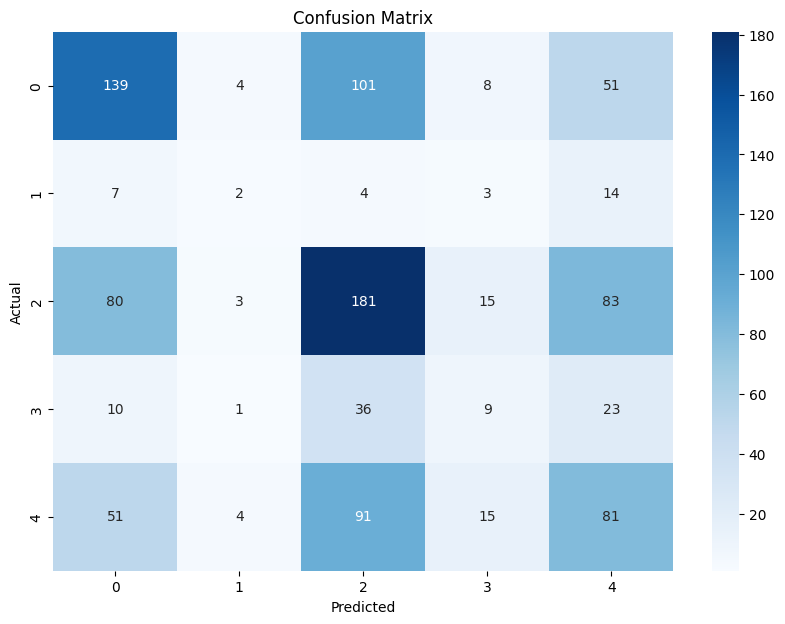

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()